In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors, create_hosvd_reconstruction_gif, analyze_pca_modes, plot_pca_spatial_modes
import global_variables 


In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
Nx, Ny = metadata['global']['Nxyz']
Nx_sub, Ny_sub = Nx//subsample_x, Ny//subsample_y
print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [3]:
component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}

  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [4]:
tensors_scaled = scale_and_center_tensors(tensors, component_names, temporal_m=True)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species  6th Species  7th Species 8th Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.4%)   YOH (6.9%)    YO 

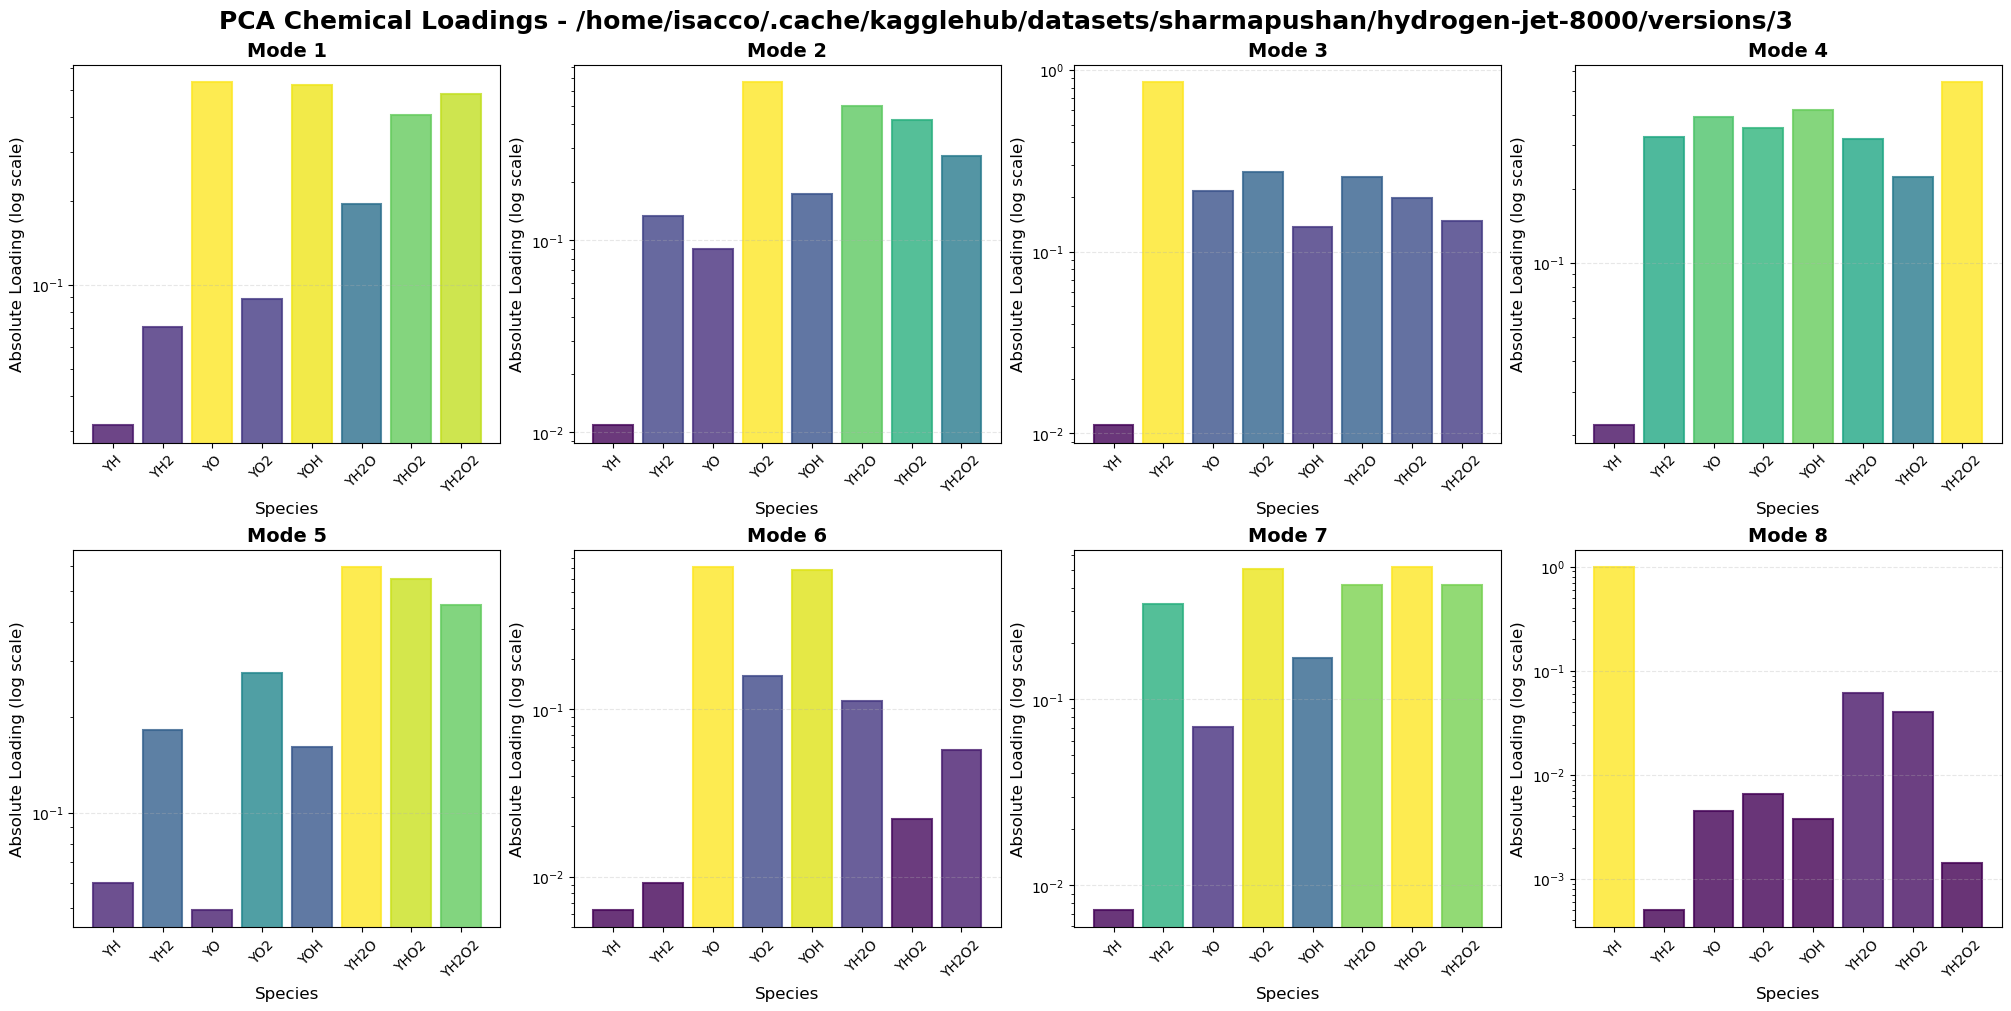

In [13]:
for dataset_path, tensor in tensors_scaled.items():
    X = np.moveaxis(tensor, 2, -1).reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U_PCA, sigma_PCA, V_PCA = np.linalg.svd(X, full_matrices=False)
    
    loadings = V_PCA.T  # Now shape is (n_components x n_modes)

df_PCA = analyze_pca_modes(loadings, component_names, dataset_path, n_top_species=8, visualize=True)

Phi shape: (6400000, 8)
Total spatial features: 6400000

Top modes energy content:
  Mode 1: 36.72%
  Mode 2: 28.39%
  Mode 3: 16.77%
  Mode 4: 6.05%
  Mode 5: 4.86%
  Mode 6: 4.03%
  Mode 7: 3.07%
  Mode 8: 0.10%


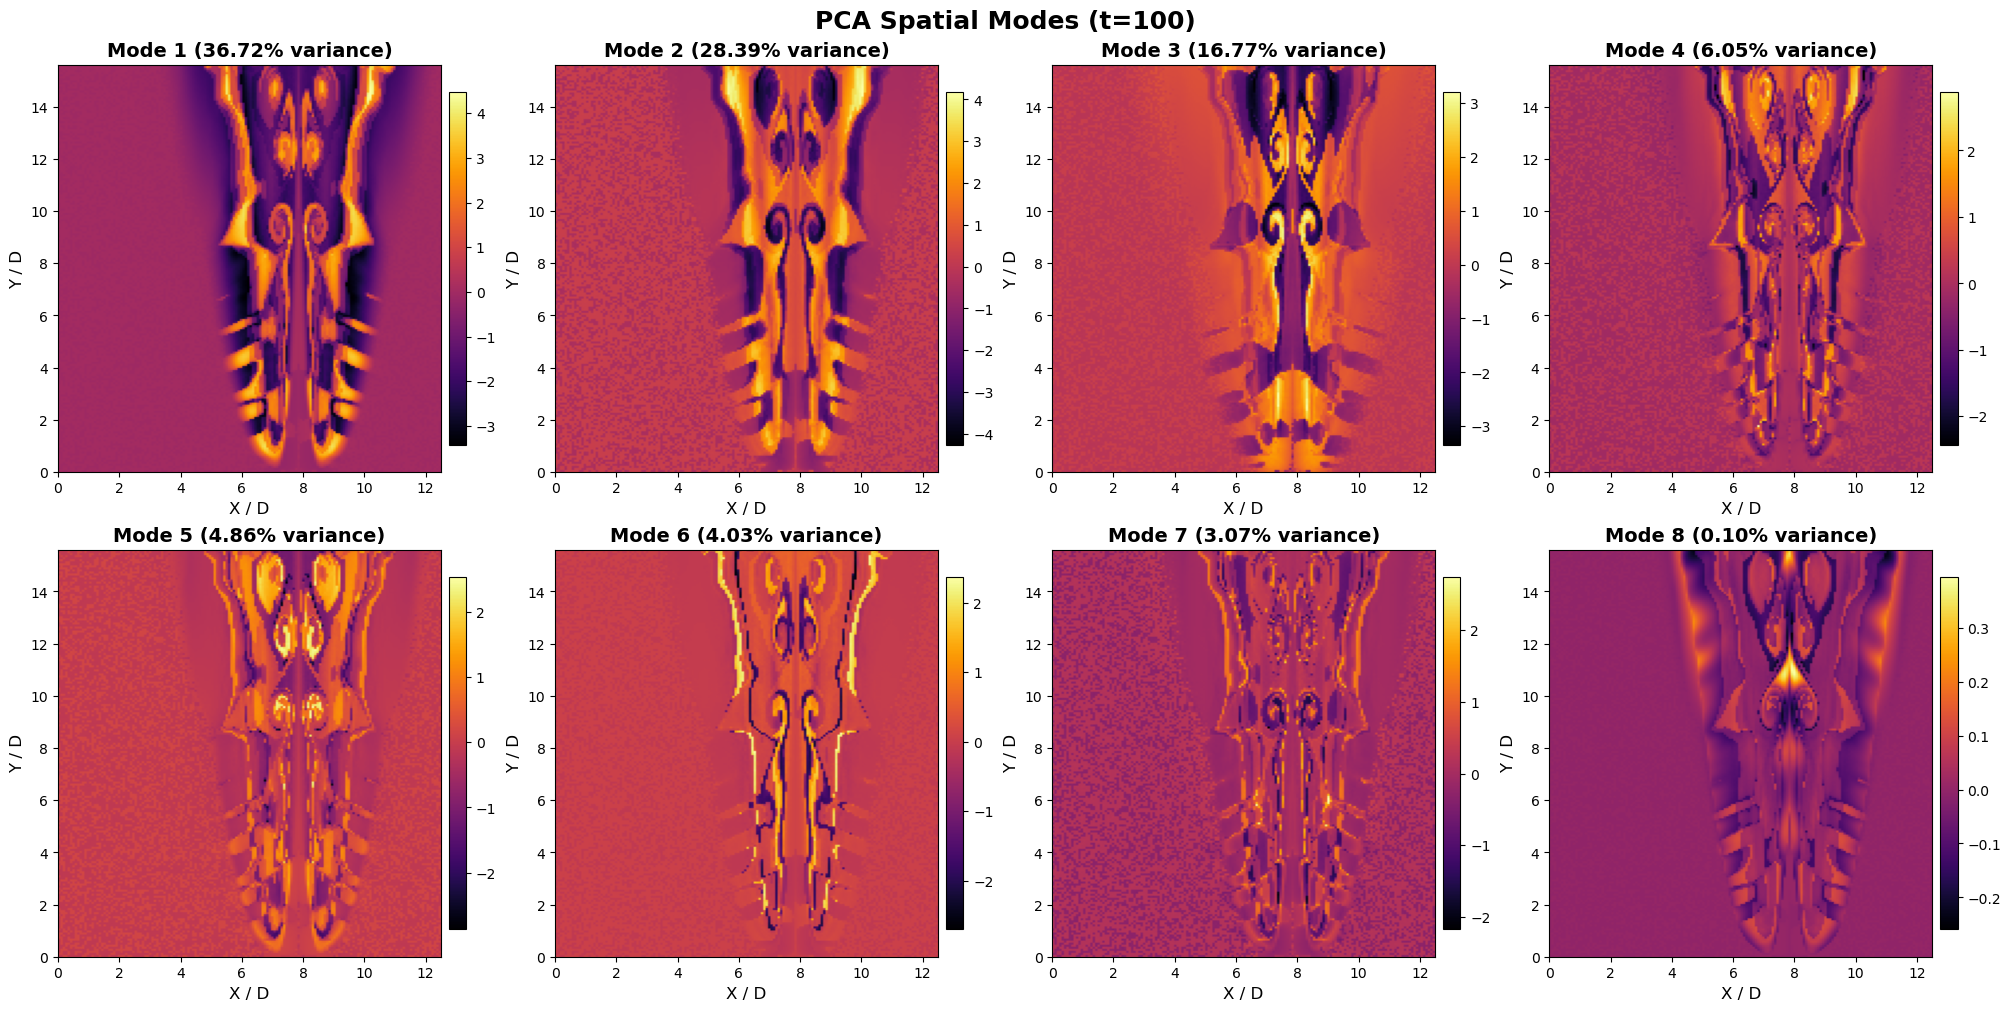

In [6]:
plot_pca_spatial_modes(U_PCA, sigma_PCA, V_PCA, Nx_sub, Ny_sub, n_modes=8, t_snapshot=100, Lx=12.5, Ly=15.6)

In [7]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    close = np.allclose(reconst, tensor)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }
print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:16<00:00,  4.09s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 3.390656e-15
----------------------------------------------------------------------------------------------------



In [8]:
for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        U_x, U_y, U_chem, U_time = f['factors']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species  6th Species  7th Species 8th Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.4%)   YOH (6.9%)    YO 

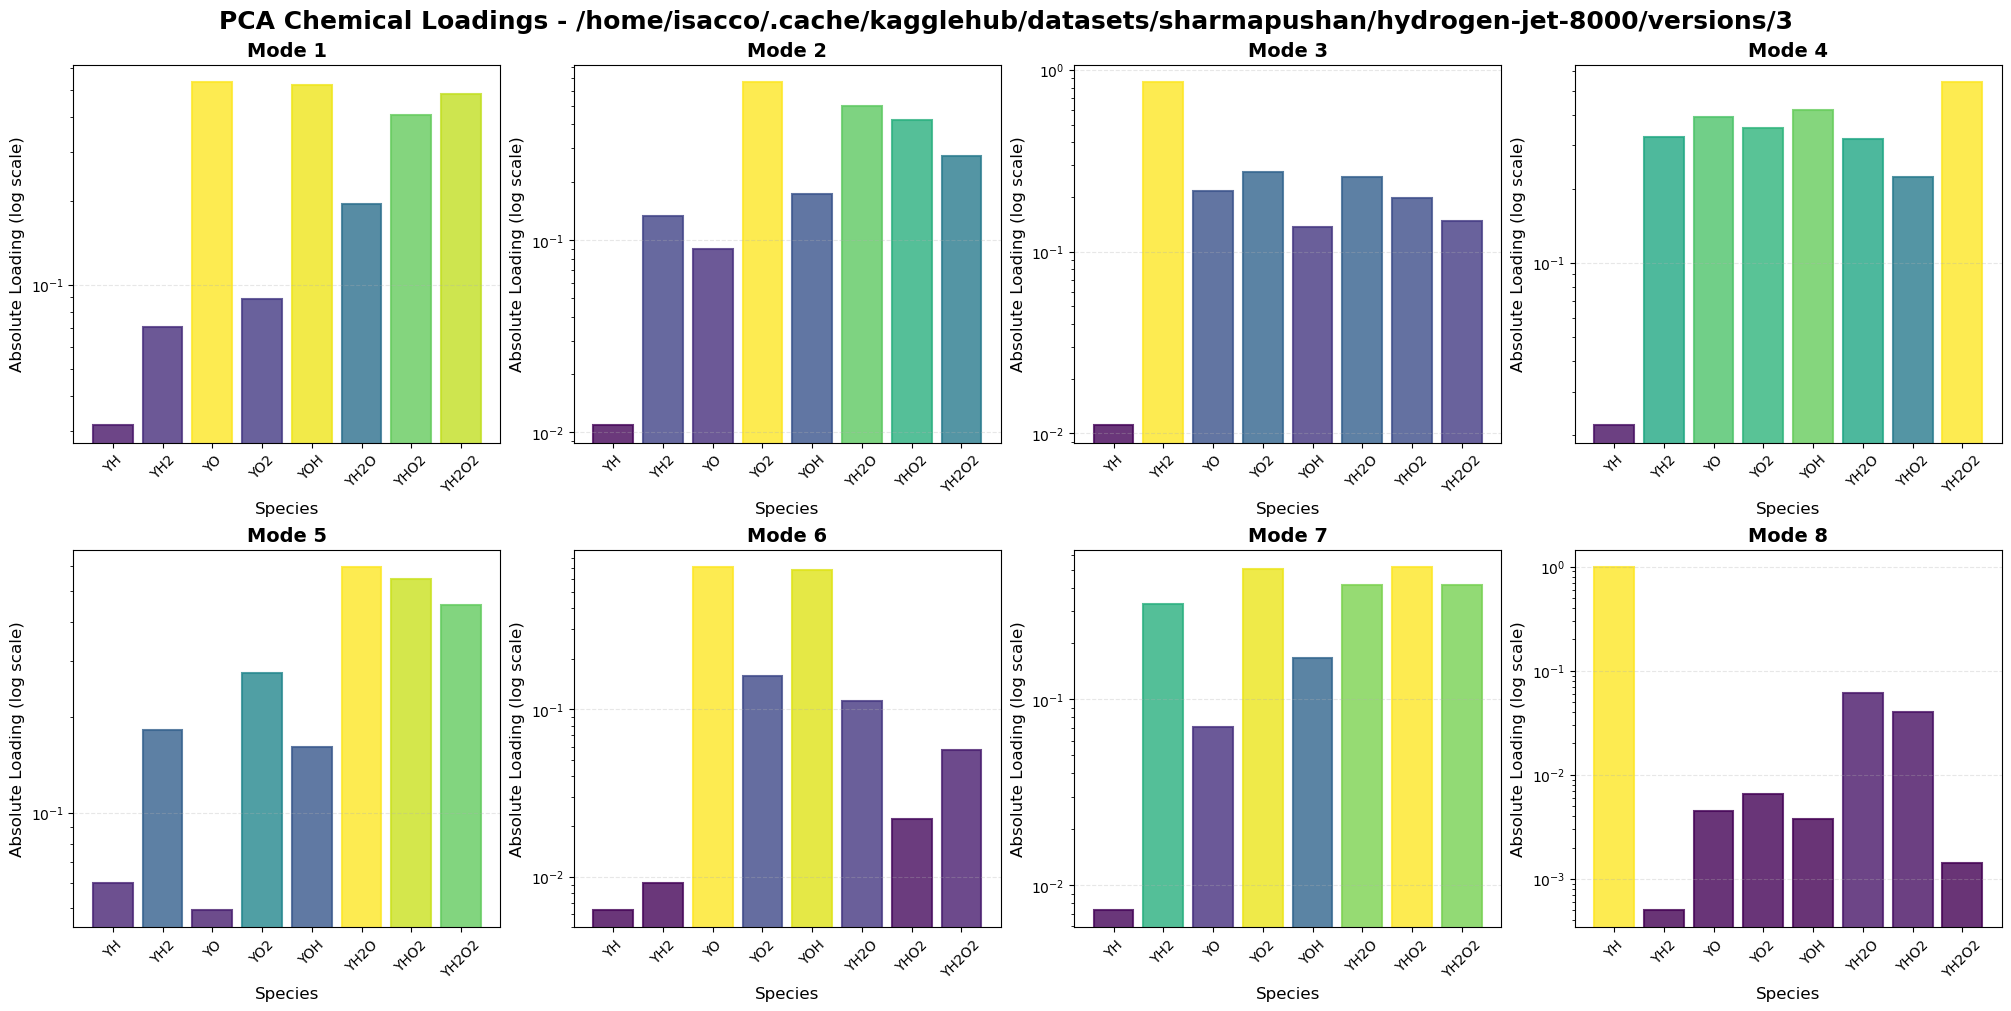

In [14]:
df_HOSVD = analyze_pca_modes(U_chem, component_names, dataset_path, n_top_species=8, visualize=True)

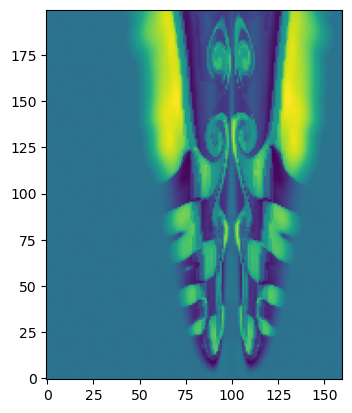

In [62]:
def PCA_reconstruction(U_PCA, sigma_PCA, V_PCA, truncation_idx = 1, Nx_sub = 160, y_size =200, n_species = 8, n_snapshots =200 ):
    X_reconstructed =  U_PCA[:, :truncation_idx] @ np.diag(sigma_PCA[:truncation_idx]) @ V_PCA[:truncation_idx, :]
    return X_reconstructed.reshape(Ny_sub, Nx_sub, n_species, n_snapshots)
reconst_PCA = PCA_reconstruction(U_PCA=U_PCA, sigma_PCA=sigma_PCA, V_PCA=V_PCA)
plt.imshow(reconst_PCA[:,:, 0 ,0], origin='lower')